In [25]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


In [2]:
data = pd.read_csv('clean.csv')

In [11]:
df = data.copy()

In [12]:
df['fecha_dato'] = pd.to_datetime(df['fecha_dato'])
product_columns = df.columns[10:34]
df_products = df[['fecha_dato', 'ncodpers'] + list(product_columns)]

df_products = df_products.sort_values(['ncodpers', 'fecha_dato'])

train_data = []
test_data = []
unique_dates = df_products['fecha_dato'].unique()

for i in range(len(unique_dates) - 1):
    current_date = unique_dates[i]
    next_date = unique_dates[i + 1]
    
    print(f"Đang xử lý tháng: {current_date}")

    current_month_data = df_products[df_products['fecha_dato'] == current_date]
    next_month_data = df_products[df_products['fecha_dato'] == next_date]
    
   
    for customer_id in current_month_data['ncodpers'].unique():
        current_customer = current_month_data[current_month_data['ncodpers'] == customer_id].iloc[0]
        next_customer = next_month_data[next_month_data['ncodpers'] == customer_id]

        if not next_customer.empty:
            next_customer = next_customer.iloc[0]
  
            new_products = next_customer[2:] - current_customer[2:]  
            new_products = new_products[new_products > 0]
              
            for product in new_products.index:

                record = {
                    'ncodpers': customer_id,
                    'fecha_dato': current_customer['fecha_dato'],
                    'output': product
                }
            
                if current_date < pd.to_datetime('2016-04-28'):
                    train_data.append(record)
                else:
                    test_data.append(record)


Đang xử lý tháng: 2015-01-28 00:00:00
Đang xử lý tháng: 2015-02-28 00:00:00
Đang xử lý tháng: 2015-03-28 00:00:00
Đang xử lý tháng: 2015-04-28 00:00:00
Đang xử lý tháng: 2015-05-28 00:00:00
Đang xử lý tháng: 2015-06-28 00:00:00
Đang xử lý tháng: 2015-07-28 00:00:00
Đang xử lý tháng: 2015-08-28 00:00:00
Đang xử lý tháng: 2015-09-28 00:00:00
Đang xử lý tháng: 2015-10-28 00:00:00
Đang xử lý tháng: 2015-11-28 00:00:00
Đang xử lý tháng: 2015-12-28 00:00:00
Đang xử lý tháng: 2016-01-28 00:00:00
Đang xử lý tháng: 2016-02-28 00:00:00
Đang xử lý tháng: 2016-03-28 00:00:00
Đang xử lý tháng: 2016-04-28 00:00:00


In [13]:
train = pd.DataFrame(train_data)
test = pd.DataFrame(test_data)

In [14]:
customer_info = df

train = train.merge(customer_info, on=['ncodpers', 'fecha_dato'], how='left')

print("Tập train:")
print(train.shape)

Tập train:
(525331, 42)


In [15]:
customer_info = df

test = test.merge(customer_info, on=['ncodpers', 'fecha_dato'], how='left')

print(test.shape)

(35843, 42)


In [16]:
#train.to_csv('train_df.csv',index=False)
#test.to_csv('test_df.csv',index=False)

In [17]:
#test_acc = test[['ncodpers','output']]
#test_acc.to_csv('test_acc.csv',index=False)

In [20]:
train = train.drop(columns = 'fecha_dato')
test = test.drop(columns = 'fecha_dato')


In [41]:
train_df = train.copy()
test_df = test.copy()

ncodpers_test = test_df['ncodpers'].values

train_df.drop(columns=['ncodpers'], inplace=True, errors='ignore')
test_df.drop(columns=['ncodpers'], inplace=True, errors='ignore')

output_col = "output"
features = [col for col in train_df.columns if col != output_col]

scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

X_train = train_df.drop(columns=['output'])
y_train = train_df['output']
X_test = test_df.drop(columns=['output'])
y_true = test_df['output']

#thông tin sản phẩm đã mua
previous_purchases = test_df.copy()

knn = KNeighborsClassifier(n_neighbors=60)
knn.fit(X_train, y_train)

y_pred_proba = knn.predict_proba(X_test)

product_labels = knn.classes_

#sắp xếp xác suất, nếu sản phẩm nào mà đã mua rồi thì lấy cái tiếp theo
sorted_preds = np.argsort(-y_pred_proba, axis=1) 

final_preds = []
for i, row in enumerate(sorted_preds):
    selected_product = None
    for j in row:  
        product = product_labels[j]  
        if previous_purchases.iloc[i][product] == 0:  
            selected_product = product
            break
    if selected_product is None:  
        selected_product = product_labels[row[0]]
    final_preds.append(selected_product)

output_df = pd.DataFrame({'ncodpers': ncodpers_test, 'output': final_preds})

output_df.to_csv("knn_predictions_filtered.csv", index=False)

print("Prediction saved to knn_predictions_filtered.csv")


Prediction saved to knn_predictions_filtered.csv


In [42]:
knn_predict = pd.read_csv('knn_predictions_filtered.csv')
knn_predict = knn_predict.drop_duplicates()

test_acc = pd.read_csv('test_acc.csv')

correct_count = 0
for index, row in knn_predict.iterrows():
    ncodpers = row['ncodpers']
    output = row['output']
    
    match = test_acc[(test_acc['ncodpers'] == ncodpers) & (test_acc['output'] == output)]
    if not match.empty:
        correct_count += 1

total_rows = len(knn_predict)
accuracy = correct_count / total_rows

print(f"Số dòng đúng: {correct_count}")
print(f"Tổng số dòng: {total_rows}")
print(f"Tỷ lệ đúng: {accuracy:.2%}")

Số dòng đúng: 20606
Tổng số dòng: 27875
Tỷ lệ đúng: 73.92%


K=5, Accuracy: 71.17%
K=10, Accuracy: 72.64%
K=15, Accuracy: 73.19%
K=20, Accuracy: 73.27%
K=25, Accuracy: 73.39%
K=30, Accuracy: 73.51%
K=35, Accuracy: 73.66%
K=40, Accuracy: 73.81%
K=45, Accuracy: 73.82%
K=50, Accuracy: 73.86%
K=55, Accuracy: 73.89%
K=60, Accuracy: 73.92%
K=65, Accuracy: 73.90%
K=70, Accuracy: 73.86%
K=75, Accuracy: 73.77%


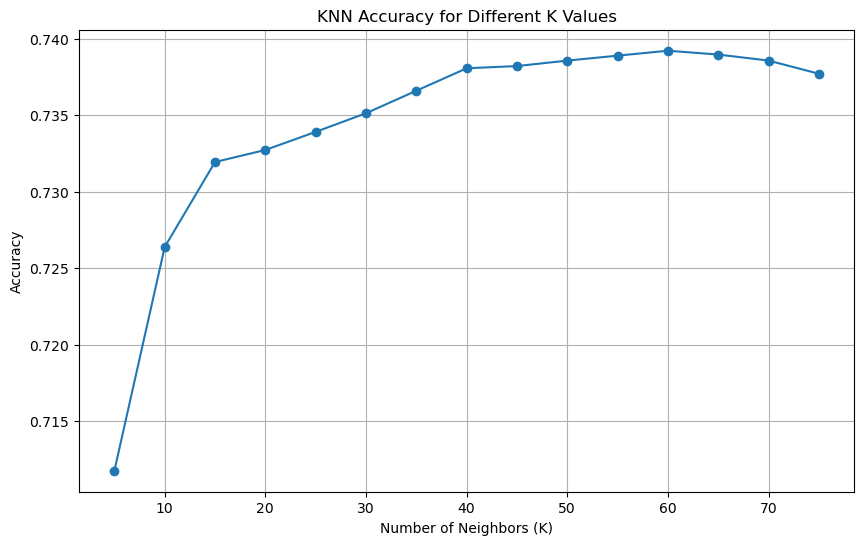

In [ ]:

train_df = train.copy()
test_df = test.copy()

ncodpers_test = test_df['ncodpers'].values

train_df.drop(columns=['ncodpers'], inplace=True, errors='ignore')
test_df.drop(columns=['ncodpers'], inplace=True, errors='ignore')

output_col = "output"
features = [col for col in train_df.columns if col != output_col]

scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

X_train = train_df.drop(columns=['output'])
y_train = train_df['output']
X_test = test_df.drop(columns=['output'])
y_true = test_df['output']

previous_purchases = test_df.copy()

k_values = list(range(5, 80, 5))
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_pred_proba = knn.predict_proba(X_test)

    product_labels = knn.classes_

    #sắp xếp xác suất, nếu sản phẩm nào mà đã mua rồi thì lấy cái tiếp theo
    sorted_preds = np.argsort(-y_pred_proba, axis=1) 

    final_preds = []
    for i, row in enumerate(sorted_preds):
        selected_product = None
        for j in row:  
            product = product_labels[j]  
            if previous_purchases.iloc[i][product] == 0:  
                selected_product = product
                break
        if selected_product is None:  
            selected_product = product_labels[row[0]]
        final_preds.append(selected_product)

    knn_predict = pd.DataFrame({'ncodpers': ncodpers_test, 'output': final_preds})
    knn_predict = knn_predict.drop_duplicates()

    test_acc = pd.read_csv('test_acc.csv')

    correct_count = 0
    for index, row in knn_predict.iterrows():
        ncodpers = row['ncodpers']
        output = row['output']
        
        match = test_acc[(test_acc['ncodpers'] == ncodpers) & (test_acc['output'] == output)]
        if not match.empty:
            correct_count += 1

    total_rows = len(knn_predict)
    accuracy = correct_count / total_rows
    accuracies.append(accuracy)
    print(f'K={k}, Accuracy: {accuracy:.2%}')

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different K Values')
plt.grid()
plt.show()